In [1]:
import os,glob
import numpy as np
import xroms
import xarray as xr
import pandas as pd
import xesmf as xe
import cartopy 
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import datetime
import romsutil as rutil
from  scipy.interpolate import interp1d
import netCDF4 as nc
%matplotlib widget

In [2]:
from dask.distributed import Client
import dask.array as da
client = Client()
client


/home/hunter/miniconda3/envs/NOPP2/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37044 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37044/status,
Dashboard: http://127.0.0.1:37044/status,Workers: 6
Total threads: 36,Total memory: 376.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43072,Workers: 6
Dashboard: http://127.0.0.1:37044/status,Total threads: 36
Started: Just now,Total memory: 376.39 GiB
Comm: tcp://127.0.0.1:45831,Total threads: 6
Dashboard: http://127.0.0.1:35464/status,Memory: 62.73 GiB
Nanny: tcp://127.0.0.1:42524,


In [3]:
%%time
#Set time
today=datetime.datetime.now().strftime('%Y%m%d')
today='20221102'

#Donor grid Info
# % Enter vertical characteristics for the L0 grid
L0grdfile='/home/hunter/roms/NOPP/forecast/grids/L0/NewEngland_qck_grid.nc' # can be a thredds url
#Vertical coordinate information
L0Vtransform= 2
L0Vstretching= 4
L0theta_s = 8.0
L0theta_b = 4.0
L0hc=200
L0N=50
#Donor inputfiles
datadir=f'/home/hunter/roms/NOPP/forecast/{today}/roms_L0/'# can be a thredds url
L0his=datadir+'roms_his_forNewEngland.nc' 
L0qck=datadir+'roms_qck_forNewEngland.nc' 


#Receiver Grid Info
L1grdfile='/home/hunter/roms/NOPP/forecast/grids/L1/NYBIGHT_grd_L1.nc' # can be a thredds url
L1theta_s=8.0
L1theta_b=4.0
L1Tcline=20.0
L1N=30
L1Vtransform  =2        #vertical transformation equation
L1Vstretching =4        #vertical stretching function
L1hc=200
Nbed=1
Nveg=1
NCS=0
NNS=1


(s_w_L0,C_w_L0)=rutil.stretching(L0Vstretching,L0theta_s,L0theta_b,L0hc,L0N,1)
(s_r_L0,C_r_L0)=rutil.stretching(L0Vstretching,L0theta_s,L0theta_b,L0hc,L0N,0)
(s_w_L1,C_w_L1)=rutil.stretching(L1Vstretching,L1theta_s,L1theta_b,L1hc,L1N,1)
(s_r_L1,C_r_L1)=rutil.stretching(L1Vstretching,L1theta_s,L1theta_b,L1hc,L1N,0)

#Receiver Output files
inifile=f'/home/hunter/roms/NOPP/output/receiver_{today}_ini.nc'
bryfile=f'/home/hunter/roms/NOPP/output/receiver_{today}_bry.nc'
clmfile=f'/home/hunter/roms/NOPP/output/receiver_{today}_clm.nc'

#Receiver Output time dimensoons
#High resolution time dimension, maybe barotropic  
t2step=1
t2N=121
t2end=t2step*t2N
#High resolution time dimension, maybe Baroclinic
t3step=8
t3N=6
t3end=t3step*t3N

#Output file flags, if True create file
INIflag=True
CLMflag=True
BRYflag=True



CPU times: user 399 µs, sys: 0 ns, total: 399 µs
Wall time: 324 µs


In [4]:
%%time
#Lazy read Grid files 
dsgrd=xr.open_dataset(L0grdfile)
dsgrd=dsgrd.drop_vars({'lon_rho', 'lat_rho', 'lon_u', 'lat_v', 'lat_u', 'lon_v'})

cfgrd=xr.open_dataset(L1grdfile)
cfgrd.attrs['sc_r']=L1N
cfgrd.attrs['sc_w']=L1N+1
cfgrd.attrs['time']=1
cfgrd.attrs['Nbed']=1
cfgrd.attrs['Nveg']=1
cfgrd.attrs['NCS']=0
cfgrd.attrs['NNS']=1
cfgrd.attrs['t2d']=t2N
cfgrd.attrs['t3d']=t3N





#Lazy read Input model files 
dsqckl0=xr.open_dataset(L0qck)
dshisl0=xr.open_dataset(L0his)
dsqckl0['s_w']=('s_w',s_w_L0)
dsqckl0['Cs_w']=('s_w',C_w_L0)
dsqckl0['s_rho']=('s_rho',s_r_L0)
dsqckl0['Cs_r']=('s_rho',C_r_L0)
dsqckl0.attrs['hc']=L0hc
dsqckl0=xr.merge([dsqckl0,dsgrd])
dsl0sub=dsqckl0.sel(ocean_time=dshisl0.ocean_time.values)



dshisl0=xr.merge([dshisl0,dsgrd])
dshisl0['ubar']=dsl0sub['ubar']
dshisl0['vbar']=dsl0sub['vbar']
dshisl0['zeta']=dsl0sub['zeta']
dshisl0['s_w']=('s_w',s_w_L0)
dshisl0['Cs_w']=('s_w',C_w_L0)
dshisl0['s_r']=('s_rho',s_r_L0)
dshisl0['Cs_r']=('s_rho',C_r_L0)
dshisl0.attrs['hc']=L0hc


#tmp=dsl0sub.zeta  
tmp=dsl0sub.rename({'mask_rho':'mask'})
tmp=tmp.rename({'lat_rho':'lat'})
tmp=tmp.rename({'lon_rho':'lon'})

lats = np.asarray(cfgrd.lat_rho).flatten()
lons = np.asarray(cfgrd.lon_rho).flatten()
masks = np.asarray(cfgrd.mask_rho).flatten()
locstream_out = True
#varnew = xr.Dataset({"lat": (["points"], lats), "lon": (["points"], lons), "mask": (["points"], masks)})
#varnew = xr.Dataset({"lat": (["points"], lats), "lon": (["points"], lons)})
varnew =cfgrd[['lon_rho','lat_rho','mask_rho']]
varnew=varnew.rename({'lat_rho':'lat'})
varnew=varnew.rename({'lon_rho':'lon'})
varnew=varnew.rename({'mask_rho':'mask'})
#regridder = xe.Regridder(tmp, varnew, "bilinear", locstream_out=locstream_out)
regridder = xe.Regridder( tmp,varnew, "bilinear",extrap_method="nearest_s2d")


CPU times: user 6.33 s, sys: 402 ms, total: 6.73 s
Wall time: 6.52 s


In [5]:
from importlib import reload
reload(rutil)

<module 'romsutil' from '/home/hunter/roms/NOPP/work/romsutil.py'>

In [6]:
rutil.create_init_file(inifile,cfgrd)

Creating Initialization file


In [7]:
%%time
if INIflag:
    rutil.create_init_file(inifile,cfgrd)
    print(f'Procesing Initilization file: {inifile}')
    rutil.create_init_file(inifile,cfgrd)
    dsqckl0_I=dsqckl0.isel(ocean_time=0)
    dshisl0_I=dshisl0.isel(ocean_time=0)
    
    
    
    (xromqckL0,gridqckL0)=xroms.roms_dataset(dsqckl0_I,Vtransform=L0Vtransform)
    uv=rutil.uv_rot_2d(xromqckL0.ubar, xromqckL0.vbar, gridqckL0,xromqckL0.angle)
    ru=uv[0]
    rv=uv[1]
    xromqckL0=xr.merge([xromqckL0,ru,rv])

    (xromhisL0,gridhisL0)=xroms.roms_dataset(dshisl0_I,Vtransform=L0Vtransform)
    uv=rutil.uv_rot(xromhisL0.u, xromhisL0.v, gridhisL0,xromhisL0.angle)
    ruhis=uv[0]
    rvhis=uv[1]
    xromhisL0=xr.merge([xromhisL0,ruhis,rvhis])

    xromhisL0=xromhisL0.rename({'mask_rho':'mask'})
    xromqckL0=xromqckL0.rename({'mask_rho':'mask'})
    tmpdsL0=xromhisL0
    xromqckL1 = regridder(xromqckL0,keep_attrs=True)
    xromhisL1 = regridder(xromhisL0,keep_attrs=True)
    tmpdsL1=xromhisL1
    
    #reset masks after interpolations
    
    xromqckL1['mask_rho']=cfgrd['mask_rho']
    
    newdims=['eta_rho','xi_rho'] 
    dim='points'
    coords=[np.arange(cfgrd.sizes['eta_rho']),np.arange(cfgrd.sizes['xi_rho'])]
    ind = pd.MultiIndex.from_product(coords, names=newdims)
    
    xromqckL1.coords[dim]=ind
    xromqckL1 = xromqckL1.unstack(dim)
    xromqckL1 = xromqckL1.assign_coords({"lon_rho": cfgrd.lon_rho,"lat_rho": cfgrd.lat_rho})
    
    xromhisL1.coords[dim]=ind
    xromhisL1 = xromhisL1.unstack(dim)
    xromhisL1 = xromhisL1.assign_coords({"lon_rho": cfgrd.lon_rho,"lat_rho": cfgrd.lat_rho})
    
#ValueError: These variables cannot be found in this dataset: ['z_w_psi0', 'z_rho_psi0']

    #xromhisL1=xromhisL1.drop({'z_w_psi','z_rho_psi','z_rho_psi0','z_w_psi0'})
    xromhisL1=xromhisL1.drop({'z_w_psi','z_rho_psi'})
    xromhisL1['lon_psi']=cfgrd['lon_psi']
    xromhisL1['lat_psi']=cfgrd['lat_psi']

    xromhisL1['xi_u']=cfgrd['xi_u']
    xromhisL1['eta_v']=cfgrd['eta_v']
    xromhisL1['mask_u']=cfgrd['mask_u']
    xromhisL1['mask_v']=cfgrd['mask_v']
    xromhisL1['lon_u']=cfgrd['lon_u']
    xromhisL1['lon_v']=cfgrd['lon_v']
    xromhisL1['lat_u']=cfgrd['lat_u']
    xromhisL1['lat_v']=cfgrd['lat_v']
    xromhisL1['mask_rho']=cfgrd['mask_rho']
    xromhisL1['s_w']=('s_w',s_w_L0)
    xromhisL1['Cs_w']=('s_w',C_w_L0)
    xromhisL1['s_rho']=('s_rho',s_r_L0)
    xromhisL1['Cs_r']=('s_rho',C_r_L0)
    xromhisL1.attrs['hc']=L0hc
    
    (xromhisL1,gridhisL1)=xroms.roms_dataset(xromhisL1,Vtransform=L0Vtransform)
    
    xromhisL1_z=xromhisL1.zeta.to_dataset()
    xromhisL1_z=xr.merge([xromhisL1_z,cfgrd])
    xromhisL1_z['s_w']=('s_w',s_w_L1)
    xromhisL1_z['Cs_w']=('s_w',C_w_L1)
    xromhisL1_z['s_rho']=('s_rho',s_r_L1)
    xromhisL1_z['Cs_r']=('s_rho',C_r_L1)
    xromhisL1_z.attrs['hc']=L1hc

    (xromhisL1_z,gridhisL1_z)=xroms.roms_dataset(xromhisL1_z,Vtransform=L1Vtransform)
        
    
    

Creating Initialization file
Procesing Initilization file: /home/hunter/roms/NOPP/output/receiver_20221102_ini.nc
Creating Initialization file


/home/hunter/miniconda3/envs/NOPP2/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/hunter/miniconda3/envs/NOPP2/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/hunter/miniconda3/envs/NOPP2/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension name

CPU times: user 9.76 s, sys: 2.99 s, total: 12.7 s
Wall time: 12.2 s


/home/hunter/miniconda3/envs/NOPP2/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/hunter/miniconda3/envs/NOPP2/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [8]:
%%time

dim_dict=xromhisL1.dims

temp = np.empty((L1N,dim_dict['eta_rho'],dim_dict['xi_rho']))
temp[:]=np.nan
salt = np.empty((L1N,dim_dict['eta_rho'],dim_dict['xi_rho']))
salt[:]=np.nan
u_east = np.empty((L1N,dim_dict['eta_rho'],dim_dict['xi_rho']))
u_east[:]=np.nan
v_north = np.empty((L1N,dim_dict['eta_rho'],dim_dict['xi_rho']))
v_north[:]=np.nan




tlat=[]
tlon=[]

for eta in range(0,dim_dict['eta_rho']):
    for xi in range(0,dim_dict['xi_rho']):
        maskflag=xromhisL1.mask_rho.isel(eta_rho=eta,xi_rho=xi).values
        if maskflag==0.0:
            continue
            

        tmpz=xromhisL1_z.z_rho.isel(eta_rho=eta,xi_rho=xi)

        
        tmp=xromhisL1.temp.isel(eta_rho=eta,xi_rho=xi)
        test=np.isnan(tmp.values).any()
        
        if test:
            tlat.append(tmp.lat_rho.values)
            tlon.append(tmp.lon_rho.values)

        ifun=interp1d(tmp.z_rho.values,tmp.values,kind='cubic',bounds_error=False,fill_value=(tmp.values[0],tmp.values[-1]))
        ntmp=ifun(tmpz.values)
        temp[:,eta,xi]=ntmp
        
        tmps=xromhisL1.salt.isel(eta_rho=eta,xi_rho=xi)
        ifuns=interp1d(tmp.z_rho.values,tmps.values,kind='cubic',bounds_error=False,fill_value=(tmps.values[0],tmps.values[-1]))
        ntmp=ifuns(tmpz.values)
        salt[:,eta,xi]=ntmp
        
        tmpu=xromhisL1.u_eastward.isel(eta_rho=eta,xi_rho=xi)
        ifunu=interp1d(tmp.z_rho.values,tmpu.values,kind='cubic',bounds_error=False,fill_value=(tmpu.values[0],tmpu.values[-1]))
        ntmp=ifunu(tmpz.values)
        u_east[:,eta,xi]=ntmp
        
        tmpv=xromhisL1.v_northward.isel(eta_rho=eta,xi_rho=xi)
        ifunv=interp1d(tmp.z_rho.values,tmpv.values,kind='cubic',bounds_error=False,fill_value=(tmpv.values[0],tmpv.values[-1]))
        ntmp=ifunv(tmpz.values)
        v_north[:,eta,xi]=ntmp
        


/home/hunter/miniconda3/envs/NOPP2/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


CPU times: user 6min 43s, sys: 29.6 s, total: 7min 13s
Wall time: 6min 43s


In [9]:
xromhisL1_z['temp']=(('s_rho', 'eta_rho', 'xi_rho'),temp)
xromhisL1_z['salt']=(('s_rho', 'eta_rho', 'xi_rho'),salt) 
xromhisL1_z['u_eastward']=(('s_rho', 'eta_rho', 'xi_rho'),u_east) 
xromhisL1_z['v_northward']=(('s_rho', 'eta_rho', 'xi_rho'),v_north) 
xromhisL1_z['vbar_northward']=xromqckL1['vbar_northward']
xromhisL1_z['ubar_eastward']=xromqckL1['ubar_eastward']
(xromhisL1_z,gridhisL1_z)=xroms.roms_dataset(xromhisL1_z,Vtransform=L1Vtransform)

uv=rutil.uv_rot_2d(xromhisL1_z.ubar_eastward, xromhisL1_z.vbar_northward, gridhisL1_z,xromhisL1_z.angle,reverse=True)
ru=uv[0]
rv=uv[1]
xromhisL1_z=xr.merge([xromhisL1_z,ru,rv])

uv=rutil.uv_rot(xromhisL1_z.u_eastward, xromhisL1_z.v_northward, gridhisL1_z,xromhisL1_z.angle,reverse=True)
ruhis=uv[0]
rvhis=uv[1]
xromhisL1_z=xr.merge([xromhisL1_z,ruhis,rvhis])

/home/hunter/miniconda3/envs/NOPP2/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/hunter/miniconda3/envs/NOPP2/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/hunter/miniconda3/envs/NOPP2/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension name

In [10]:
print(inifile)
ncid = nc.Dataset(inifile, "r+", format="NETCDF4")

ncid.variables['ubar'][0,:,:]=xromhisL1_z.ubar.values[:,:]
ncid.variables['vbar'][0,:,:]=xromhisL1_z.vbar.values[:,:]
ncid.variables['zeta'][0,:,:]=xromhisL1_z.zeta.values[:,:]
ncid.variables['u'][0,:,:,:]=xromhisL1_z.u.values[:,:,:]
ncid.variables['v'][0,:,:,:]=xromhisL1_z.v.values[:,:,:]
ncid.variables['salt'][0,:,:,:]=xromhisL1_z.salt.values[:,:,:]
ncid.variables['temp'][0,:,:,:]=xromhisL1_z.temp.values[:,:,:]
ncid.sync()
ncid.close()

/home/hunter/roms/NOPP/output/receiver_20221102_ini.nc


In [ ]:
proj = cartopy.crs.Mercator(central_longitude=-98)
pc = cartopy.crs.PlateCarree()
fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(3,1,1,projection=pc)
gl = ax2.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False


tmp=xromhisL1_z.salt.values[-1,:,:]
#tmp=da2.isel(ocean_time=0,s_rho=0)
#ax2.add_feature(shape_feature2)
#pm=ax2.pcolormesh(xromhisL1.lon_rho,xromhisL1.lat_rho,tmp,cmap="binary_r"))
pm=ax2.pcolormesh(xromhisL1.lon_rho,xromhisL1.lat_rho,tmp)
#pm=ax2.pcolormesh(xromhisL1.lon_rho,xromhisL1.lat_rho,tmp)

#plt.plot(xromhisL1.lon_rho,xromhisL1.lat_rho,'g+')
#plt.plot(dsqckl0.lon_rho,dsqckl0.lat_rho,'mo')
ax2.coastlines()
plt.colorbar(pm)
plt.plot(tlon,tlat,'r+')

36.08831222786638
56.60844906712988


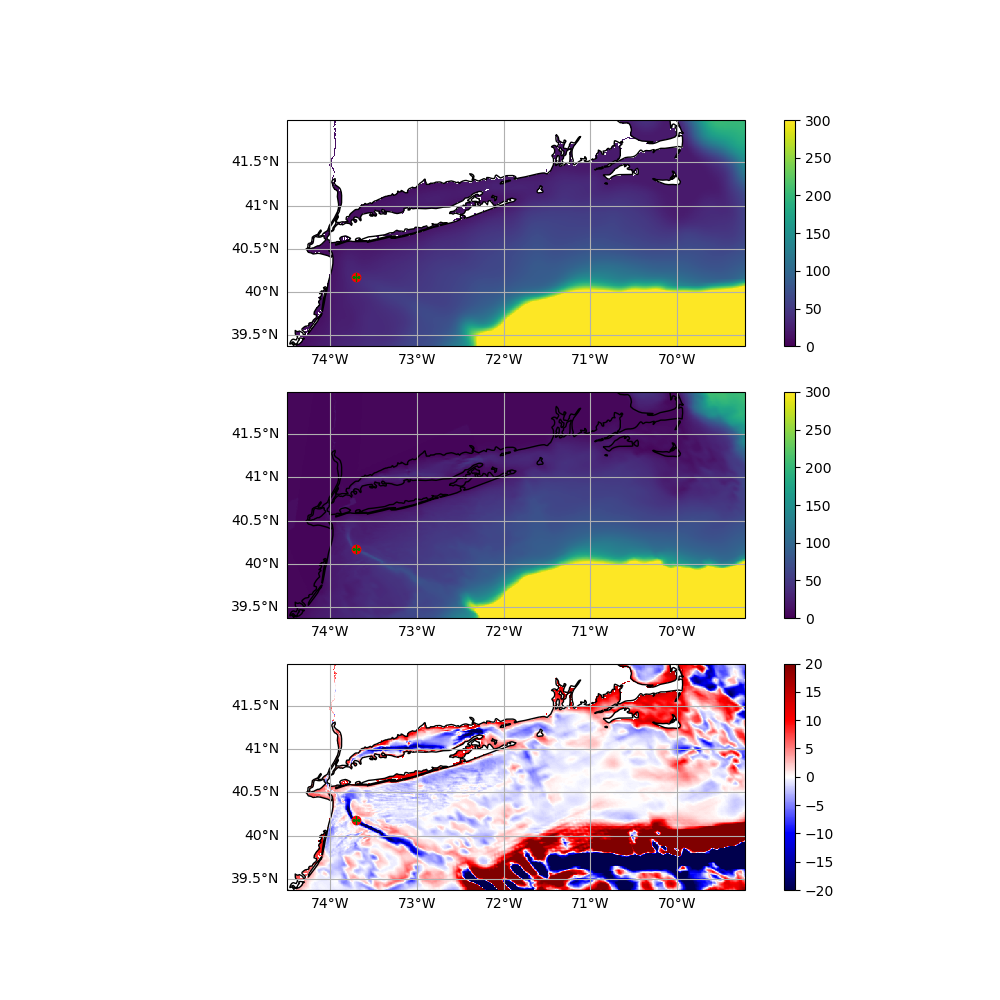

In [16]:
#tmpLL0=xromhisL1.h.isel(eta_rho=30,xi_rho=300)
#tmpLL1=xromhisL1_z.h.isel(eta_rho=30,xi_rho=300)
tmpLL0=xromhisL1.h.isel(eta_rho=100,xi_rho=100)
tmpLL1=xromhisL1_z.h.isel(eta_rho=100,xi_rho=100)
print(tmpLL0.values)
print(tmpLL1.values)
proj = cartopy.crs.Mercator(central_longitude=-98)
pc = cartopy.crs.PlateCarree()
fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(3,1,1,projection=pc)
gl = ax2.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
#coast_10m = cfeature.NaturalEarthFeature(
#    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
#)
#ax2.add_feature(coast_10m)

# shape_feature2 = ShapelyFeature([BBOX],
#                                 pc, edgecolor='red', facecolor='none')

#tmp=xromhisL1.z_w.isel(s_w=-1)
tmp=xromhisL1.h
#tmp=da2.isel(ocean_time=0,s_rho=0)
#ax2.add_feature(shape_feature2)
pm=ax2.pcolormesh(tmp.lon_rho,tmp.lat_rho,tmp,vmin=0,vmax=300)
ax2.coastlines()
plt.colorbar(pm)
plt.plot(tmpLL0.lon_rho,tmpLL0.lat_rho,'ro')
plt.plot(tmpLL1.lon_rho,tmpLL1.lat_rho,'g+')

ax3 = fig2.add_subplot(3,1,2,projection=pc)
gl = ax3.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
#coast_10m = cfeature.NaturalEarthFeature(
#    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
#)
#ax2.add_feature(coast_10m)

# shape_feature2 = ShapelyFeature([BBOX],
#                                 pc, edgecolor='red', facecolor='none')

#tmp=xromhisL1.zeta
tmp=xromhisL1_z.h
#tmp=da2.isel(ocean_time=0,s_rho=0)
#ax2.add_feature(shape_feature2)
pm=ax3.pcolormesh(tmp.lon_rho,tmp.lat_rho,tmp,vmin=0,vmax=300)
ax3.coastlines()
plt.colorbar(pm)
plt.plot(tmpLL0.lon_rho,tmpLL0.lat_rho,'ro')
plt.plot(tmpLL1.lon_rho,tmpLL1.lat_rho,'g+')



ax4 = fig2.add_subplot(3,1,3,projection=pc)
gl = ax4.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

#tmp=xromhisL1.zeta
tmp=xromhisL1.h-xromhisL1_z.h

#tmp=da2.isel(ocean_time=0,s_rho=0)
#ax2.add_feature(shape_feature2)
pm=ax4.pcolormesh(tmp.lon_rho,tmp.lat_rho,tmp,vmin=-20,vmax=20,cmap='seismic')
ax4.coastlines()

plt.plot(tmpLL0.lon_rho,tmpLL0.lat_rho,'ro')
plt.plot(tmpLL1.lon_rho,tmpLL1.lat_rho,'g+')
plt.colorbar(pm)



